In [1]:
import pickle
from pathlib import Path

import arviz as az
import jax.numpy as jnp
from jax.tree_util import tree_map
from mubelnet.utils import perplexity
from scipy.stats import entropy

In [2]:
from dataset import load_mutation_spectrum, COSMIC_WEIGHTS


X_train, X_test = load_mutation_spectrum()


MODEL = 'poisson_gamma_believe'
_bottom_layer_name = (
    f"{MODEL}/~/multinomial_layer"
    if MODEL == "multinomial_dirichlet_believe"
    else f"{MODEL}/~/poisson_layer"
)

2023-09-26 13:18:18.029742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
state_dir = Path('/tmp/poisson_gamma_believe/78/samples')
pickles = sorted(state_dir.glob('sample_*.pkl'))
# Load the states from the pickles and concatenate along the second axis.
state_checkpoints = []
for p_file in pickles[-6:]:
    with open(p_file, 'rb') as fi:
        states = pickle.load(fi)
        states_thinned = tree_map(lambda x: x[:, ::5], states)
        del states
        state_checkpoints.append(states_thinned)

states = tree_map(lambda *xs: jnp.concatenate(xs, axis=1), *state_checkpoints)

In [4]:
def probability(state):
    bottom_state = state[_bottom_layer_name]
    phi = COSMIC_WEIGHTS.to_numpy()
    theta = bottom_state["theta"]
    probs = theta @ phi
    probs /= probs.sum(axis=-1, keepdims=True)
    return probs

def evaluate(params, states, X, axis=[0, 1]):
    """Compute perplexity over chains and samples by default (axis=[0, 1])."""
    probs = probability(params, states).mean(axis)
    return perplexity(X, probs)

Evaluate performance

In [5]:
from statkit.non_parametric import bootstrap_score

probs = probability(states).mean(axis=[0, 1])
pp_estimate_1 = bootstrap_score(X_test, probs, metric=perplexity, random_state=42)
print("Perplexity on unseen observations", pp_estimate_1)
print(pp_estimate_1.latex())

Perplexity on unseen observations 6.20e+01 (95 % CI: 6.13e+01-6.27e+01)
6.20$^{+0.07}_{-0.07} \cdot 10^{1}$


In [6]:
# Convert states to arviz inference data.
r_entropy = entropy(states["poisson_gamma_believe/~/cap_layer"]["r"], axis=-1)
theta_entropy = entropy(states["poisson_gamma_believe/~/cap_layer"]["theta"], axis=-1)
idata = az.convert_to_inference_data(
    {
        "c": states["poisson_gamma_believe/~/cap_layer"]["c"],
        "s[r]": r_entropy,
        "s[theta]": theta_entropy,
    }
)

In [7]:
del states
isummary = az.summary(idata)
isummary

/home/hylke/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


/home/hylke/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<AxesSubplot:title={'center':'s[r]'}>,
        <AxesSubplot:title={'center':'s[r]'}>]], dtype=object)

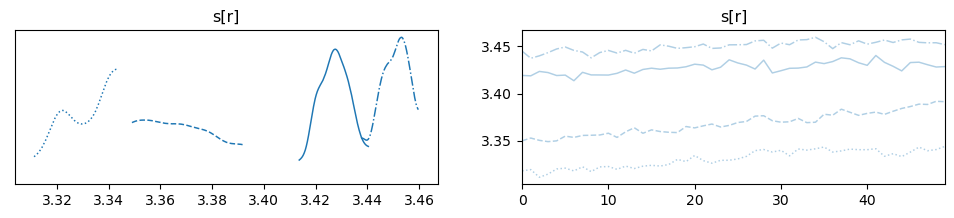

In [9]:
az.plot_trace(idata, var_names=["s[r]"])

In [10]:
theta_cols = [c_name for c_name in isummary.index if 'theta' in c_name]
c_cols = [c_name for c_name in isummary.index if 'c' in c_name]

In [11]:
isummary.loc[theta_cols]['r_hat'].describe()

count    4645.000000
mean        1.598564
std         0.460540
min         1.000000
25%         1.240000
50%         1.500000
75%         1.830000
max         3.770000
Name: r_hat, dtype: float64

In [13]:
isummary.loc[c_cols]['r_hat'].describe()

count    4645.000000
mean        1.015856
std         0.015645
min         0.990000
25%         1.000000
50%         1.010000
75%         1.020000
max         1.100000
Name: r_hat, dtype: float64